# Исследование эффективности рекламной кампании и целесообразности распределения рекламного бюджета 

<div style="border:solid green 2px; padding: 20px">
<b>Закачик - развлекательное приложение "Procrastinate Pro+" </b>
    
<b>Описание исследования:</b>

<b>Задача</b> - Несмотря на значительные вложения в рекламные кампании, целью которых является привлечение новых пользователей приложения, бизнес уже несколько месяцев несет убытки. Необходимо выявить причины.
    
<b>Цели исследования изучить:</b> 
- как люди пользуются продуктом;
- когда они начинают покупать;
- сколько денег приносит каждый клиент;
- когда привлеченный клиент окупается;
- какие факторы отрицательно влияют на привлечение пользователей.   
    
<b>Данные</b> - Предоставлены лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 
    
<b>Описание данных</b>    
_Таблица visits_log_short (лог сервера с информацией о посещениях сайта):_
- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session start — дата и время начала сессии
- Session End — дата и время окончания сессии
- Channel — идентификатор рекламного источника, из которого пришел пользователь
- Region - страна пользователя

_Таблица orders_log_short (информация о заказах):_
- User Id — уникальный id пользователя, который сделал заказ
- Event Dt — дата и время покупки
- Revenue — выручка

_Таблица costs_short (информация о затратах на маркетинг):_
- Channel — идентификатор рекламного источника
- Dt — дата
- Costs — затраты на этот рекламный источник в этот день    

## Шаг 1. Загрузка данных и их подготовка к анализу

### Импорт библиотек и загрузка исследуемых данных

In [1]:
# импортирую все библиотеки, которые могут понадобиться в ходе исследования
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
from math import factorial
import statsmodels.api as sm
from datetime import datetime, timedelta

In [2]:
# отключаю системные предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
# хочу видеть все таблицы полностью, если они будут слишком объемными
pd.set_option('display.max_columns', 100)

In [4]:
# загружаю исследуемые таблицы
# использую try / except для оптимизации перехода с работы на платформе на локальный режим
try:
    visits, orders, costs = (pd.read_csv('/datasets/visits_info_short.csv'),
                             pd.read_csv('/datasets/orders_info_short.csv'),
                             pd.read_csv('/datasets/costs_info_short.csv'))
except:
    visits, orders, costs = (pd.read_csv('../Downloads/visits_info_short.csv'),
                             pd.read_csv('../Downloads/orders_info_short.csv'),
                             pd.read_csv('../Downloads/costs_info_short.csv'))
 
# сразу проверю написание названий колонок в исследуемых таблицах  
display(visits.columns)
display(orders.columns)
costs.columns

Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')

Index(['User Id', 'Event Dt', 'Revenue'], dtype='object')

Index(['dt', 'Channel', 'costs'], dtype='object')

### Переименование столбцов

In [5]:
# Приведу названия столбцов к "змеиному" регистру.
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

display(visits.columns)
display(orders.columns)
costs.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Index(['dt', 'channel', 'costs'], dtype='object')

### Знакомство с данными

In [6]:
# познакомлюсь с данными в таблицах

print('Информация о таблице с данными о посещении сайта')
display(visits.head())
display(visits.info())
print('Информация о таблице с данными о заказах')
display(orders.head())
display(orders.info())
print('Информация о таблице с данными о расходах на маркетинг')
display(costs.head())
costs.info()

Информация о таблице с данными о посещении сайта


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

Информация о таблице с данными о заказах


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

Информация о таблице с данными о расходах на маркетинг


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Смена типов данных
Информация о датах содержится в следующих столбцах:
-  visits['session_start'];
-  visits['session_end'];
-  orders['event_dt'];
-  costs['dt'].

Однако, все из перечисленных столбцов имеют тип object. Приведу эти столбцы к типу datetime.

In [7]:
# приведение столбцов к типу  datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Проверка на пропуски
В этапе 1.3 "Знакомство с данными" при помощи метода info() было обнаружено, что абсолютно все столбцы имеют одинаковое число значений, но на всякий случай проведу проверку на пропущенные значения.

In [8]:
# проверка таблиц на пропущенные значения
print('Информация о пропусках в данных о посещении сайта')
display(visits.isna().sum())
print('Информация о пропусках в данных о заказах')
display(orders.isna().sum())
print('Информация о пропусках в данных о расходах на маркетинг')
costs.isna().sum()

Информация о пропусках в данных о посещении сайта


user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

Информация о пропусках в данных о заказах


user_id     0
event_dt    0
revenue     0
dtype: int64

Информация о пропусках в данных о расходах на маркетинг


dt         0
channel    0
costs      0
dtype: int64

### Проверка на наличие полных дубликатов

In [9]:
# проверка таблиц на наличие дубликатов
print('Информация о дубликатах в данных о посещении сайта')
display(visits.duplicated().sum())
print('Информация о дубликатах в данных о заказах')
display(orders.duplicated().sum())
print('Информация о дубликатах в данных расходах на маркетинг')
costs.duplicated().sum()

Информация о дубликатах в данных о посещении сайта


0

Информация о дубликатах в данных о заказах


0

Информация о дубликатах в данных расходах на маркетинг


0

### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
- Все данные приведены к нужному формату.
- В данных отсутствуют пропуски, что не может не радовать.
- Не пришлось избавляться от явнях дубликатов, так как их в данных нет.
    
Данные готовы для анализа и да начнется расследование.   

## Шаг 2. Задача функций для расчета и анализа LTV, ROI, удержания и конверсии


### Функция для создания пользовательских профилей

В теоретической части функция содержала раздел о событиях. В исследуемых данных я не распалаю данными о событиях, поэтому слегла облегчу функцию. Надеюсь она не сломается:)

In [10]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчета удержания

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для раасчета конверсии

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта LTV и ROI

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для сглаживания фрейма

In [14]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации удержания

In [15]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для визуализации конверсии

In [16]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

###   Функция для визуализации LTV и ROI

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Исследовательский анализ данных

#### Получение пользовательских профилей

Итак, да данном шаге я приступаю к самой интересной части проекта - исследовательскому анализу. В первую очередь, получу данные о профилях пользователей при помощи ранее заданной таблицы get_profiles(). Я помню, что я ее несколько сократила, но надеюсь, что не сломала и она будет работать.


In [18]:
profiles = get_profiles(visits, orders, costs)
display(profiles.info())
profiles.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


None

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Все работает, ничего не поломано. Это ли не счастье?
Но мне бы хотелось перепроверить себя, поэтому проверю число уникальных значений пользователей в таблице с информацией о посещениях.

In [19]:
len(visits['user_id'].unique())

150008

Все отлично, 150008 уникальных user_id и столько же строк в таблице с информацией о профилях. Данные собраны корректно.

#### Установка необходимых дат

Для дальнейшего анализа необходимо установить минимальную и максимальную даты привлечения пользователей. Эти даты я буду устанавливать при помощи данных, представленных в таблице с данными о профилях.

In [20]:
# установка минимальной даты привлечения пользователей
min_analysis_date = profiles['first_ts'].min().date()
display(min_analysis_date)

# установка максимальной даты привлечения пользователей
max_analysis_date = profiles['first_ts'].max().date()
max_analysis_date

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

Как и было описано в задании, я имею дело с данными от 1 мая 2019 года по 27 октября 2019 года, то есть почти за 6 месяцев.

#### Исследование профилей пользователей из разных стран

На данном шаге необходимо ответить на 2 вопроса:
- Из каких стран приходят посетители?
- Какие страны дают больше всего платящих пользователей?

Для ответа перввый вопрос построю сводную таблицу.

##### Из каких стран приходят посетители?

In [21]:
profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)


,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


Всего в приложение приходят пользователи из 4-х стран:
- США;
- Великобритания;
- Франция;
- Германия.

Больше всего пользователей из США, свыше 100 тыс. пользователей, что почти в 6 раз больше, своего ближайшего "приследователя". Примерно развное число пользователей из Франции и Великобритании, около 17,5 тыс. человек. Меньше всего пользователей из Германии - чуть меньше 15 тыс. человек.

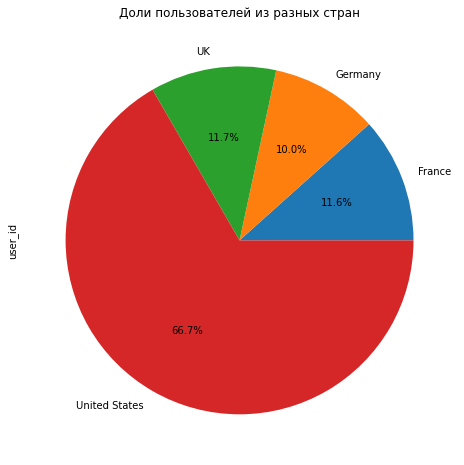

In [22]:
(profiles.groupby('region')['user_id'].nunique().plot(kind='pie', figsize=(8, 8), 
         title='Доли пользователей из разных стран', autopct='%1.1f%%'));

Очень хорошо видно преобладание числа пользователей из США по отношениею к другим странам на графике.

##### Какие страны дают больше всего платящих пользователей?

Определять из какой страны больше всего платящих пользователей я также буду при помощи группировки, как и в шаше выше, но в данном случае я добавлю срез, и возьму для построения таблицы только платящих пользователей.

In [23]:
profiles.query('payer == True').groupby('region').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)


,user_id
region,
United States,6902
UK,700
France,663
Germany,616


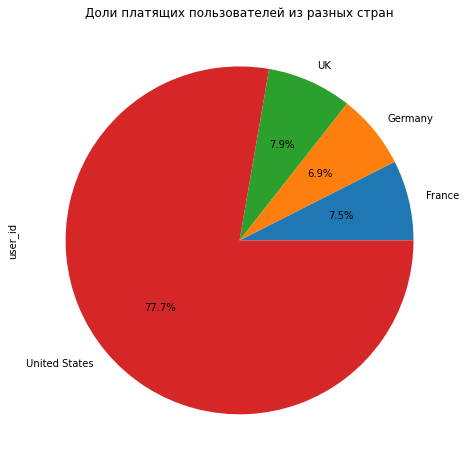

In [24]:
(profiles.query('payer == True').groupby('region')['user_id'].nunique().plot(kind='pie', figsize=(8, 8), 
         title='Доли платящих пользователей из разных стран', autopct='%1.1f%%'));

От общего числа платящих пользователей:
- 77,7% из США
- 7,9% из Великобритании
- 7,5% из Франции
- 6,9% из Германии.

Но сами по себе эти цифры не могут дать мне полезную информацию об эффективности рекламных кампаний. Сейчас с увереностью можно сказать только то, что самую большую часть прибыли для бизнеса приносят пользователи из США.
Для формирования выводов об эффективвности рекламных кампаний, необходимо понять какую долю составляют платящие пользователи от общего числа пользователей из определенной страны. Для этого я соберу еще одну таблицу.

In [25]:
# таблица с информацией о общем числе пользователей из разных стран
regions_1 = profiles.pivot_table(index='region', values = ['user_id'], 
                                             aggfunc=['count']).reset_index()

# таблица с информацией о числе платящих пользователей из разных стран
regions_2 = profiles.query('payer == True').pivot_table(index='region', values = ['user_id'], 
                                             aggfunc=['count']).reset_index()

# таблица с общей информацие по странам
regions_3 = regions_1.merge(regions_2, how='outer', on='region')
# избавляюсь от нескольких строк в названии столбцови даю им корректные названия
regions_3.columns = ['region', 'total_users', 'payer_users']
# определяю долю платящих пользователей от общего числа пользователей
regions_3['fraction %'] = (regions_3['payer_users'] / regions_3['total_users']) * 100
# вывод таблицы с сортировкой доли по убыванию
regions_3.sort_values(by='fraction %', ascending=False).style.format({'fraction %': '{:.2f}%'})

,region,total_users,payer_users,fraction %
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


Результаты весьма не утешительные. Самач большая доля платящих пользователей, по отношениею к общему числу пользователей, в США, но она составлет всего 6,9% от общего числа. В остальных странах эта доля составляет около 4%. Пльзователей много, но покупок они почти не совершают.

### Исследование профилей пользователей в зависимости от устройства

На данном шаге необходимо выяснить:
- Какими устройствами пользуются пользователи.
- Какие устройства предпочитают платящие пользователи.

Как и в предыдущем шаге не обойтись без сводной таблицы.

#### Какими устройствами пользуются пользователи

In [26]:
profiles.groupby('device').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
device,
iPhone,54479
Android,35032
PC,30455
Mac,30042


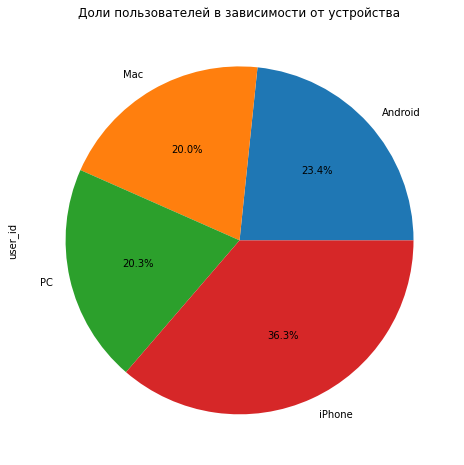

In [27]:
(profiles.groupby('device')['user_id'].nunique().plot(kind='pie', figsize=(8, 8), 
         title='Доли пользователей в зависимости от устройства', autopct='%1.1f%%'));

Лучше всего общую долю демонстрирует диаграмма типа пирог.
Всего пользователи используют следующие устроства, и стоит отметить, что в целом доли распределены примерно одинаково:
- iPhone - самое большое число пользователей, 54,4 тыс. человек или 36,3%
- Android - второе по популярности устройство, 35,5 тыс. человек или 23,4% от общего числа пользователей
- PC - 30,4 тыс. пользователей и 20,3% от общего числа
- Mac - 30 тыс. пользователей и 20% от общего числа, что практически равно доли пользователей на PC.

#### Какие устройства предпочитают платящие пользователи

In [28]:
profiles.query('payer == True').groupby('device').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
device,
iPhone,3382
Android,2050
Mac,1912
PC,1537


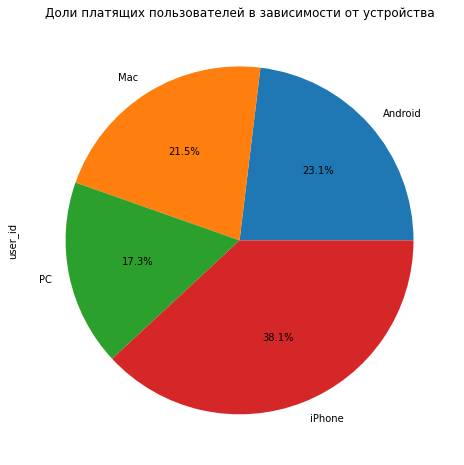

In [29]:
(profiles.query('payer == True').groupby('device')['user_id'].nunique().plot(kind='pie', figsize=(8, 8), 
         title='Доли платящих пользователей в зависимости от устройства', autopct='%1.1f%%'));

Чаще всего покупки в приложении делают пользователи IPhone - 38,1% от общего числа платящих пользователей или 3382 человека.
В остальном доли распределены примерно одинаково:
- Android - 2050 пользователей или 23,1%
- Mac - 1912 пользователя или 21,5%
- PC - 1537 пользователей или 17,3%, что является самой маленькой долей платящих пользователей.

Сравнимо с предыдущим шагом с анализом стран, я вычислю доли платящих пользователей от общаго числа в зависимости от используемого устройства.

In [30]:
# таблица с информацией о общем числе пользователей в зависимости от устройства
device_1 = profiles.pivot_table(index='device', values = ['user_id'], 
                                             aggfunc=['count']).reset_index()

# таблица с информацией о числе платящих пользователей  в зависимости от устройства
device_2 = profiles.query('payer == True').pivot_table(index='device', values = ['user_id'], 
                                             aggfunc=['count']).reset_index()

# таблица с общей информацие по устройствам
device_3 = device_1.merge(device_2, how='outer', on='device')
# избавляюсь от нескольких строк в названии столбцови даю им корректные названия
device_3.columns = ['device', 'total_users', 'payer_users']
# определяю долю платящих пользователей от общего числа пользователей
device_3['fraction %'] = (device_3['payer_users'] / device_3['total_users']) * 100
# вывод таблицы с сортировкой доли по убыванию
device_3.sort_values(by='fraction %', ascending=False).style.format({'fraction %': '{:.2f}%'})

,device,total_users,payer_users,fraction %
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


В данном случае наблюдается различие - не смотря на тот факт, что на Mac приходится меньше всего пользователей, именно на этом устройстве самая большая доля платящих пользователей от общего числа пользователей в зависимости от устройства.
В остальном доли распределены следующим образом:
- IPhone - 6,21%, что не многим ниже ниже доли платящих пользователей Mac
- Android - 5,85%
- PC - 5,05%

Результаты в целом не впечатляющие, но есть предположение, что стоит проверить как работает приложение на Android и PC, ведь на них не самое низкое число пользователей, однако самый низкий процент оплат. Возможно есть какие-то проблемы в работе приложения. 

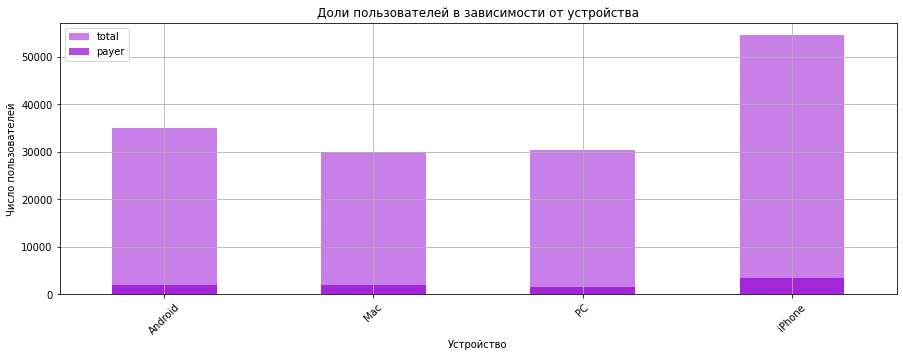

In [31]:
ax = profiles.groupby('device')['user_id'].count().plot(x='device', y='user_id',
    kind='bar', grid=True, figsize=(15, 5), label='total', alpha = 0.5, color='darkviolet')

profiles.query('payer == True').groupby('device')['user_id'].count().plot(x='device', y='user_id',
    kind='bar', grid=True, figsize=(15, 5), label='payer', alpha = 0.7, color='darkviolet', ax=ax)

plt.ylabel('Число пользователей')
plt.xlabel('Устройство')
plt.xticks(rotation = 45)
ax.legend()
ax.set_title('Доли пользователей в зависимости от устройства')
plt.show()

На графике выше наглядно видно на сколько малы доли пользователей, которые совершают покупки.

### Исследование рекламных источников

Результаты шага помогут мне понять реклама в каком канале привлекла наибольшее число платящих пользователей.

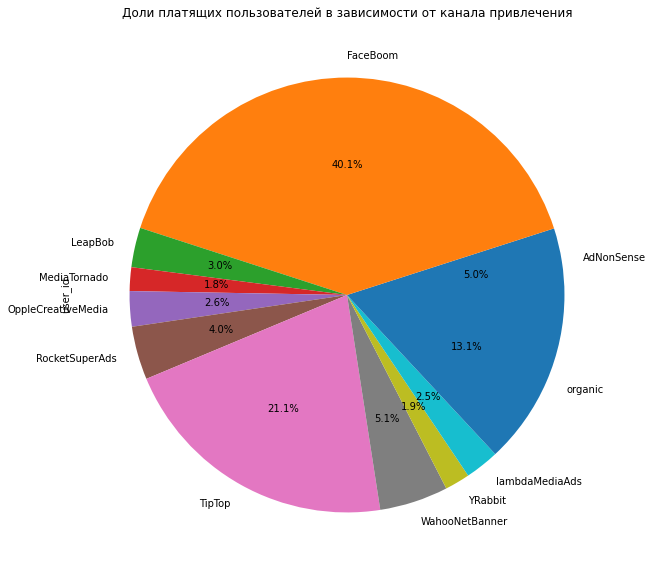

In [32]:
(profiles.query('payer == True').groupby('channel')['user_id'].nunique().plot(kind='pie', figsize=(10, 10), 
         title='Доли платящих пользователей в зависимости от канала привлечения', autopct='%1.1f%%'));

Можно выделить 3 основных канала, привлекшего наибольшее число пользователей:
- FaceBoom
- TipTop
- organic

In [33]:
# таблица с информацией о общем числе пользователей в зависимости от канала привлечения
channel_1 = profiles.pivot_table(index='channel', values = ['user_id'], 
                                             aggfunc=['count']).reset_index()

# таблица с информацией о числе платящих пользователей в зависимости от канала привлечения
channel_2 = profiles.query('payer == True').pivot_table(index='channel', values = ['user_id'], 
                                             aggfunc=['count']).reset_index()

# таблица с общей информацие по каналам привлечения 
channel_3 = channel_1.merge(channel_2, how='outer', on='channel')
# избавляюсь от нескольких строк в названии столбцови даю им корректные названия
channel_3.columns = ['channel', 'total_users', 'payer_users']
# определяю долю платящих пользователей от общего числа пользователей
channel_3['fraction %'] = (channel_3['payer_users'] / channel_3['total_users']) * 100
# вывод таблицы с сортировкой доли по убыванию
channel_3['total_fraction %'] = (channel_3['payer_users'] / channel_3['payer_users'].sum()) * 100
channel_3.sort_values(by=('total_fraction %') ,ascending=False).style.format({'fraction %': '{:.2f}%', 'total_fraction %': '{:.2f}%'})

,channel,total_users,payer_users,fraction %,total_fraction %
1,FaceBoom,29144,3557,12.20%,40.05%
6,TipTop,19561,1878,9.60%,21.15%
10,organic,56439,1160,2.06%,13.06%
7,WahooNetBanner,8553,453,5.30%,5.10%
0,AdNonSense,3880,440,11.34%,4.95%
5,RocketSuperAds,4448,352,7.91%,3.96%
2,LeapBob,8553,262,3.06%,2.95%
4,OppleCreativeMedia,8605,233,2.71%,2.62%
9,lambdaMediaAds,2149,225,10.47%,2.53%
8,YRabbit,4312,165,3.83%,1.86%


Самое большое число платящих пользоватлей были привлечены из следующих каналов:
- FaceBoom - 29144 пользователя или 46.07% от общего числа платящих пользоватлей
- TipTop - 19561 человек или 24.32%
- WahooNetBanner - 8553 пользователя или 5.87%

Не смотря на то, что канал organic третий по доле платящих пользователей, только 2% из них совершают покупки в приложении. Из этого можно сделать выводы:
- реклама нужна
- необходимо обратить дополнительное внимание на этот канал - учитывая, что пользователи бесплатн приходят в приложение и их доля очень велика, стоит проработать возможности побуждениях их к покупке. Этот канал не требует рекламных затрат и может стать потенциально самым эффективным.

Однако, если смотреть на доли платящих пользователе в зависимости от определенного канала, то лидеры будут несколько другие:
- FaceBoom - 12.2% пользователей, привлеченных этим каналом, совершают покупки
- AdNonSense - 11.34% пользователей, привлеченных этим каналом, совершают покупки
- lambdaMediaAds - 10.47% пользователей, привлеченных этим каналом, совершают покупки
- TipTop - 9.60% пользователей, привлеченных этим каналом, совершают покупки

Аутсайдерами среди каналов привлечения можно назвать:
- MediaTornado
- YRabbit

Эти каналы не имеют положительных моментов, и на них приходится низкий процент привлеченных пользователей, низкий процент платящих пользователей, и малая доля пользователей, привлеченных этим каналом, совершает покупки.

Посмотрю на графике на распределение долей платящих пользователей по отношению к общему числу пользователей, привлеченных из определенного канала.

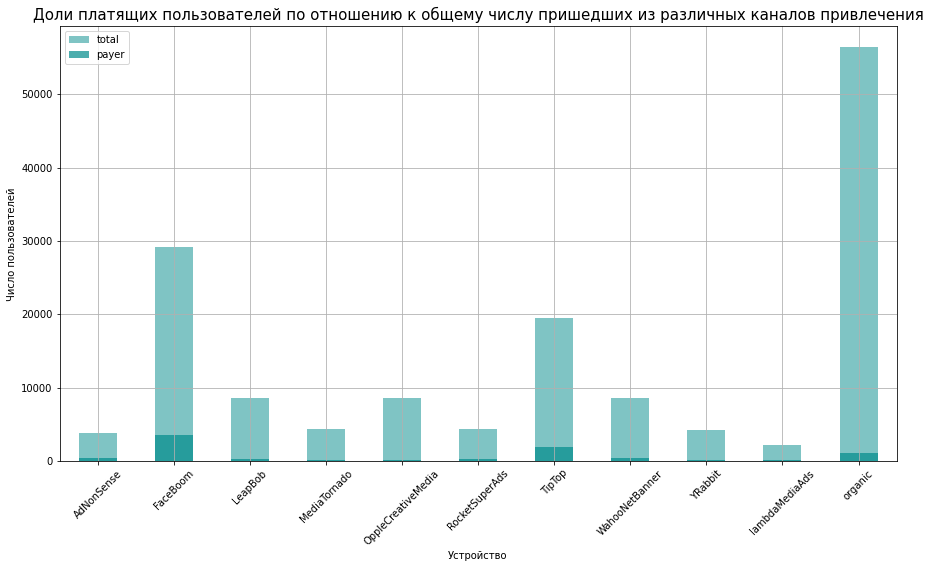

In [34]:
ax = profiles.groupby('channel')['user_id'].count().plot(x='channel', y='user_id',
    kind='bar', grid=True, figsize=(10, 9), label='total', alpha = 0.5, color='DarkCyan')

profiles.query('payer == True').groupby('channel')['user_id'].count().plot(x='channel', y='user_id',
    kind='bar', grid=True, figsize=(15, 8), label='payer', alpha = 0.7, color='DarkCyan', ax=ax)

plt.ylabel('Число пользователей')
plt.xlabel('Устройство')
ax.legend()
plt.xticks(rotation = 45)
ax.set_title('Доли платящих пользователей по отношению к общему числу пришедших из различных каналов привлечения', fontsize=15)
plt.show()

График отображает на сколько мал процент пользоватлей, привлеченных в приложение из различных каналов, совершают покупки.

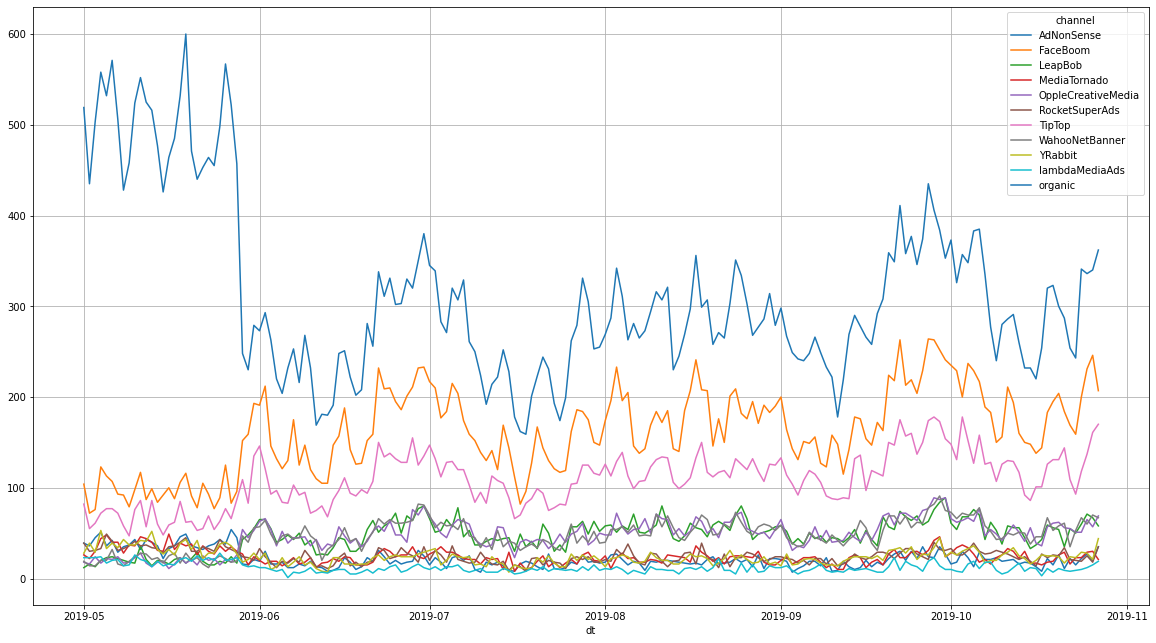

In [35]:
# в качестве практики построю график, предложенный в теории
%matplotlib inline

profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(20, 11), grid=True)

plt.show()

Интересным будет подробно изучить всплеск привлеченных пользователей из канала organic в мае 2019 года.

### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
<b>Исследование стран</b> 
- Больше всего приложением пользуются в США - почти 67%
- Примерно одинаково пользуются приложением в Великобритании, Франции и Германии - 10-11%
    
- Самая большая доля платящих пользователей призодится на США - почти 78%
- По сравнению с лидером, в Великобритании, Франции и Германии практически нет платящих пользователей - 7-8% от общего числа
    
- Чаще всего пользователи США переходят в статус латящих пользователей, но процент все равно очень низкий - 6,9%
- Только примерно 3% пользователей от числа пользователей в Великобритании, Германии и Франции делают покупки     
    
<b>Исследование устройств</b>    
- Чаще всего пользователи приложений используют iPhone - 36,3%
- Примерно одинаково используют Android, PC и Mac - 20-23% пользователей на каждое из устройств
    
- Чаще всего покупки совершают пользователи iPhone - 38,1% от общего числа покупающих пользователей
- На Mac и Android приходится примерно равный процент платящих пользователей - 21-23%
- Реже всего совершают покупку пользователи PC - 17,5%
    
- Около 6% от общего числа пользователей iPhone и Mac делаают покупки
- 5,85% пользователей Android делают покупки
- Хуже всего делают покупки пользователи PC - 5,05%, не смотря на то, что устройство не занимает последнее место среди всех устройств по числу пользователей.
    
<b>Исследование каналов привлечения</b>  
Самое большое число платящих пользоватлей были привлечены из следующих каналов:
- FaceBoom - 29144 пользователя или 46.07% от общего числа платящих пользоватлей
- TipTop - 19561 человек или 24.32%
- WahooNetBanner - 8553 пользователя или 5.87%

Однако, если смотреть на доли платящих пользователе в зависимости от определенного канала, то лидеры будут несколько другие:
- FaceBoom - 12.2% пользователей, привлеченных этим каналом, совершают покупки
- AdNonSense - 11.34% пользователей, привлеченных этим каналом, совершают покупки
- lambdaMediaAds - 10.47% пользователей, привлеченных этим каналом, совершают покупки
- TipTop - 9.60% пользователей, привлеченных этим каналом, совершают покупки

Аутсайдерами среди каналов привлечения можно назвать:
- MediaTornado
- YRabbit
    
При этом одним из самых популярных каналов привлечения новых пользователей является не рекламный канал organic.
    
<font color='green'><b>Предварительные рекомендации</b>
- Проверить работу приложения на PC
- Исследовать скачек привлечения новых клиентов в мае 2019 года через канал organic.    

## Шаг 4. Маркетинг

### Общие расходы на рекламу
#### Общие расходы на рекламу всего

Расходы на рекламу содержаться в таблице costs. Найду общие расходы на рекламу, как сумму значений столбца 'сosts'. Общие расходы на рекламу помещу в переменную total_acquisition_cost.

In [36]:
total_acquisition_cost = round(costs['costs'].sum()) # отброшу знаки после запятой
print(f'Общие расходы на рекламу в период с 1 мая по 27 октября 2019 года составили {total_acquisition_cost} у.е.')

Общие расходы на рекламу в период с 1 мая по 27 октября 2019 года составили 105497 у.е.


#### Общие расходы на рекламу на каждый источник привлечения

Как я отметила ранее, в рамках исследования целесообразности расходов на рекламные кампании, меня не интересует канал привлечения organic, так как пользователи из него приходят бесплатно, сами собой.
Именно поэтому, для исследования расходов на каждый платный канал привлечения, я исключу "органических" пользователей.

In [37]:
# исключаю органических пользователей
channels_costs = profiles.query('channel != "organic"').pivot_table(index='channel', values = ['acquisition_cost'], 
                                             aggfunc=['sum']).reset_index()
# назначаю корректные наименования столбцов
channels_costs.columns = ['channel', 'sum_costs']
# создаю столбец общей долей вложений на канал
channels_costs['fraction %'] = (channels_costs['sum_costs'] / total_acquisition_cost) * 100
# вывожу таблицу использую сортировку доли по убыванию
channels_costs.sort_values(by=('fraction %') ,ascending=False).style.format({'fraction %': '{:.2f}%'})

,channel,sum_costs,fraction %
6,TipTop,54751.300000,51.90%
1,FaceBoom,32445.600000,30.75%
7,WahooNetBanner,5151.000000,4.88%
0,AdNonSense,3911.250000,3.71%
4,OppleCreativeMedia,2151.250000,2.04%
5,RocketSuperAds,1833.000000,1.74%
2,LeapBob,1797.600000,1.70%
9,lambdaMediaAds,1557.600000,1.48%
3,MediaTornado,954.480000,0.90%
8,YRabbit,944.220000,0.90%


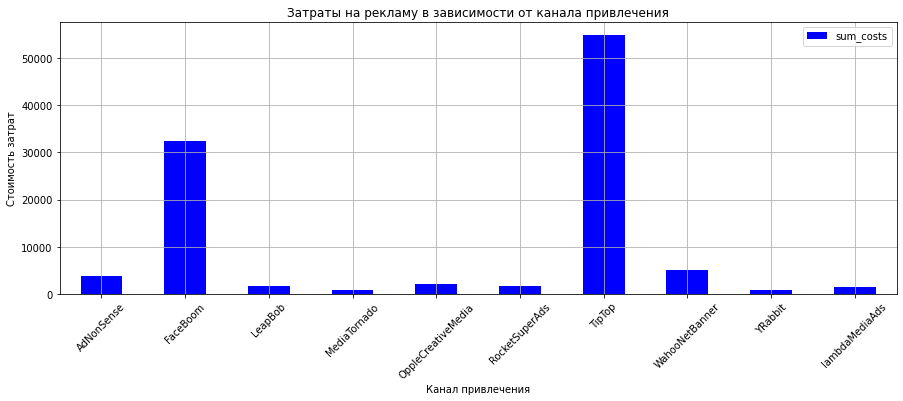

In [38]:
# добавлю наглядности графически
channels_costs.plot(x='channel', y='sum_costs',kind='bar', grid=True, figsize=(15, 5),
                    title = 'Затраты на рекламу в зависимости от канала привлечения', color='Blue');
plt.ylabel('Стоимость затрат')
plt.xlabel('Канал привлечения')
plt.xticks(rotation = 45)
plt.show()

На графике отчетливо видно, какой приоритет маркетологи приложения Procrastinate Pro+ отдают TipTop. Результаты следующие:
- 1 место и почти 52% рекламного бюджета - TipTop
- 2 место и почти 31% рекламного бюджета - FaceBoom
- 3 место и всего 4.9% рекламного бюджета - WahooNetBanner
- на остальные 7 источников приходится оставшиеся 12,5% общих рекламных затрат.

#### Общие расходы на рекламу по времени

In [39]:
# исключаю органических пользователей
date_costs = profiles.query('channel != "organic"').pivot_table(index='month', values = ['acquisition_cost'], 
                                             aggfunc=['sum']).reset_index()
# назначаю корректные наименования столбцов
date_costs.columns = ['month', 'sum_costs']
# создаю столбец общей долей вложений на канал
date_costs['fraction %'] = (date_costs['sum_costs'] / total_acquisition_cost) * 100
# вывожу таблицу использую сортировку доли по убыванию
date_costs.sort_values(by=('fraction %') ,ascending=False).style.format({'fraction %': '{:.2f}%'})

,month,sum_costs,fraction %
4,2019-09-01 00:00:00,22441.340000,21.27%
5,2019-10-01 00:00:00,20882.415000,19.79%
3,2019-08-01 00:00:00,20657.870000,19.58%
2,2019-07-01 00:00:00,16447.060000,15.59%
1,2019-06-01 00:00:00,15090.045000,14.30%
0,2019-05-01 00:00:00,9978.570000,9.46%


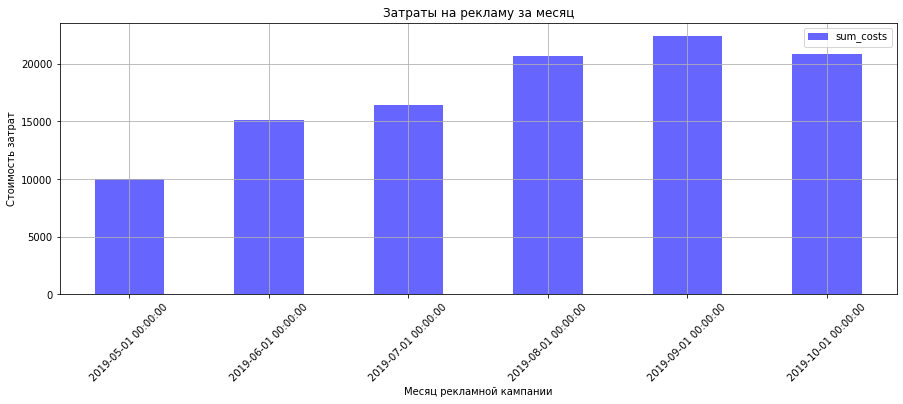

In [40]:
date_costs.plot(x='month', y='sum_costs',kind='bar', grid=True, figsize=(15, 5),
                    title = 'Затраты на рекламу за месяц', alpha = 0.6, color='Blue');
plt.ylabel('Стоимость затрат')
plt.xlabel('Месяц рекламной кампании')
plt.xticks(rotation = 45)
plt.show()

Затраты на рекламу распределились следующим образом:
- больше всего было затрачено на рекламу в сентябре - 21,3%
- в августе и октябре(не полныы данные за месяц) - около 19,5%
- схожие затраты на рекламу были в июне и июле - 14,3% и 15,6% соответственно
- меньше всего было потрачено в мае - 9,5%

Посомотрю на динамику расходов на рекламу.

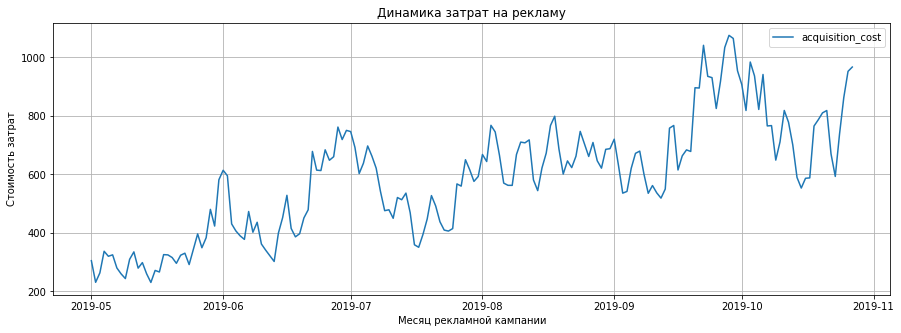

In [41]:
%matplotlib inline

profiles.query('channel != "organic"').pivot_table(
    index='dt',  # даты первых посещений
    values='acquisition_cost',  # расходы на рекламу
    aggfunc='sum'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.ylabel('Стоимость затрат')
plt.xlabel('Месяц рекламной кампании')
plt.title('Динамика затрат на рекламу')
plt.show()

График отображает как с каждым месяцем росли расходы на рекламу. Хорошо видно пик в октябре. Также стоит отметить резкие снижения в июне и июле. Судя по тому как идет график, в концу октября ожидается еще один пик затрат на рекламу.

Можно посмотреть динамику с разбивкой по каналам.

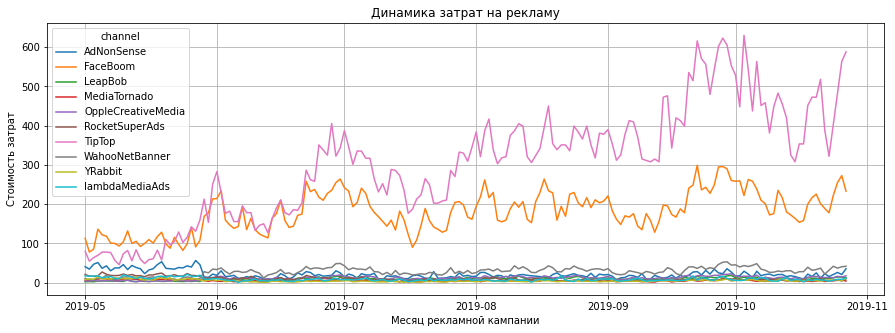

In [42]:
%matplotlib inline

profiles.query('channel != "organic"').pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',
    values='acquisition_cost',  # расходы на рекламу
    aggfunc='sum'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.ylabel('Стоимость затрат')
plt.xlabel('Месяц рекламной кампании')
plt.title('Динамика затрат на рекламу')
plt.show()

Хорошо видно, что расходы на рекламу в каналах TipTop и FaceBoom растут на поряжении всего исследуемого периода. Возможно это причина, что из всех коммерческих каналов привлечения, эти привели больше всего пользователей. График более наглядно показал, почему эти каналы забрали львиную долю рекламного бюджета.

#### Общие расходы на рекламу в зависимости от региона

Ранее стало известно, что наибольшее число пользователей пишло в США. Поэтому мне хочется проверить расходы на рекламу в зависимости от региона привлечения.

In [43]:
# исключаю органических пользователей
region_costs = profiles.query('channel != "organic"').pivot_table(index='region', values = ['acquisition_cost'], 
                                             aggfunc=['sum']).reset_index()
# назначаю корректные наименования столбцов
region_costs.columns = ['region', 'sum_costs']

# создаю столбец общей долей вложений на страну
region_costs['fraction %'] = (region_costs['sum_costs'] / total_acquisition_cost) * 100
# вывожу таблицу использую сортировку доли по убыванию
region_costs.sort_values(by=('fraction %'), ascending=False).style.format({'fraction %': '{:.2f}%'})

,region,sum_costs,fraction %
3,United States,90928.600000,86.19%
0,France,5075.973946,4.81%
2,UK,5068.502819,4.80%
1,Germany,4424.223235,4.19%


Не удивительно, что из США самый большой приток пользователей - именно на этот регион затрачивается 86% от общего размера реклманых затрат.

### Стоимость привлечения одного покупателя из каждого источника

Для расчета средней стоимости привлечение одного пользователя (CAC) из каждого канала привлечения, необходимо общие размеры затран на рекламу в определенном канале, разделить на число привлеченных из него пользователей. Ранее я использовала метод query, так как ради собственного любопытства переодически проверяла органических пользователей. Сейчас же я просто избавлю таблицу с информацией о профилях пользователей, от тех, что пришел не благодаря рекламе.

In [44]:
profiles = profiles.query('channel != "organic"')
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000


In [45]:
cac_total = total_acquisition_cost / len(profiles['user_id'].unique())
print(f'Общий CAC по всему проекту составляет {round(cac_total, 2)} у.е.')

Общий CAC по всему проекту составляет 1.13 у.е.


In [46]:
cac_channel = profiles.pivot_table(index='channel', values = ['acquisition_cost'], aggfunc=['mean']).reset_index()
cac_channel.columns = ['channel', 'mean_costs']
cac_channel['mean_costs'] = round(cac_channel['mean_costs'], 2)
cac_channel.sort_values(by=('mean_costs'), ascending=False)

,channel,mean_costs
6,TipTop,2.80
1,FaceBoom,1.11
0,AdNonSense,1.01
9,lambdaMediaAds,0.72
7,WahooNetBanner,0.60
5,RocketSuperAds,0.41
4,OppleCreativeMedia,0.25
3,MediaTornado,0.22
8,YRabbit,0.22
2,LeapBob,0.21


Самым дорогим каналом привлечения, с точки зрения CAC является TipTop, привлечение 1 пользователя из этого канала в среднем приходится в 2,8 у.е. Стоит отметить, что это более, чем вдвое дороже чем стоимость привлечения одного пользователя по всем рекламным каналам вместе взятым.
Самым дешевым каналом привлечения является LeapBob - 0,2 у.е.

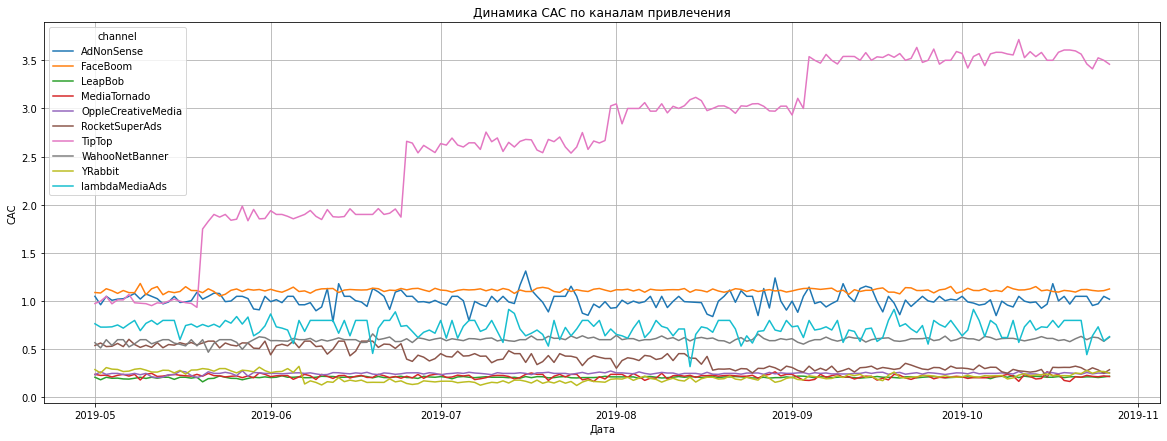

In [47]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 7))
plt.ylabel('CAC')
plt.xlabel('Дата')
plt.title('Динамика CAC по каналам привлечения')
plt.show()

На графике очень хорошо видно, что с каждым месяцем стоимость привлечения пользователей через канал TipTop растет. При этом CAC по другим каналам привлечения остается примерно на одном уровне. При этом ранее было определено, что на данный канал приходится примерно 24% платящих пользователей, и почти в 1,5 раза меньше привлеченных пользователей, чем канал через FaceBoom, рекламные расходы на который меньше, чем расходы на  TipTop.

### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
<b>Общие расходы на рекламу</b> в период с мая по октябрь 2019 года составили 105497 у.е.

<b>Расходы на рекламу в зависимости от канала привлечения</b> распределились следующим образом:
- 1 место и почти 52% рекламного бюджета - TipTop
- 2 место и почти 31% рекламного бюджета - FaceBoom
- 3 место и всего 4,9% рекламного бюджета - WahooNetBanner
- на остальные 7 источников приходится оставшиеся 12,5% общих рекламных затрат

<b>Расходы на рекламу по времени:</b>    
- больше всего было затрачено на рекламу в сентябре - 21,3%
- в августе и октябре (не полныы данные за месяц) - около 19,5%
- схожие затраты на рекламу были в июне и июле - 14,3% и 15,6% соответственно
- меньше всего было потрачено в мае - 9,5% 
- в июне и июле зафиксированы снижения расходов на рекламу
- с сентября по октябрь наблюдается стабильное возрастание расходов на рекламу и в октябре ожидается очередной пик расходов
    
<b>Стоимость привлечения одного пользователя по всем канала в целом</b> - составила 1,13 у.е.
    
<b>Стоимость привлечения одного пользователя из разных каналов </b> распределилась следующим образом:
- TipTop самый дорогой канал вовлечения - привлечение 1 пользователя из этого канала в среднем приходится в 2,8 у.е. Это в полтора раза больше стоимости привлечения 1 пользователя по всем каналом в целом
- Самым дешевым каналом привлечения является LeapBob - 0,2 у.е.
    
Стоимость привлечения пользователя через канал TipTop растет с каждым месяцем (с мая по октябрь с примерно 1 у.е. до 3,5 у.е), при этом канал не является самым успешным ни с точки зрения платящих пользователей, ни с точки зрения пользователей в целом.
    
<font color='green'><b>Предварительная рекомендация:</b>    
Пересмотреть расходы на рекламу через канал TipTop, так как он является самым дорогим, но не далеко не самым эффективным.     

## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [48]:
# задам необходимые переменные
observation_date = datetime(2019, 11, 1).date() # момент анализа, согласно условиям это 1 ноября 2019 года
horizon_days = 14 # согласно условиям окупаемость должна наступить не позднее, чем через 2 недели

### Проанализируйте общую окупаемость рекламы

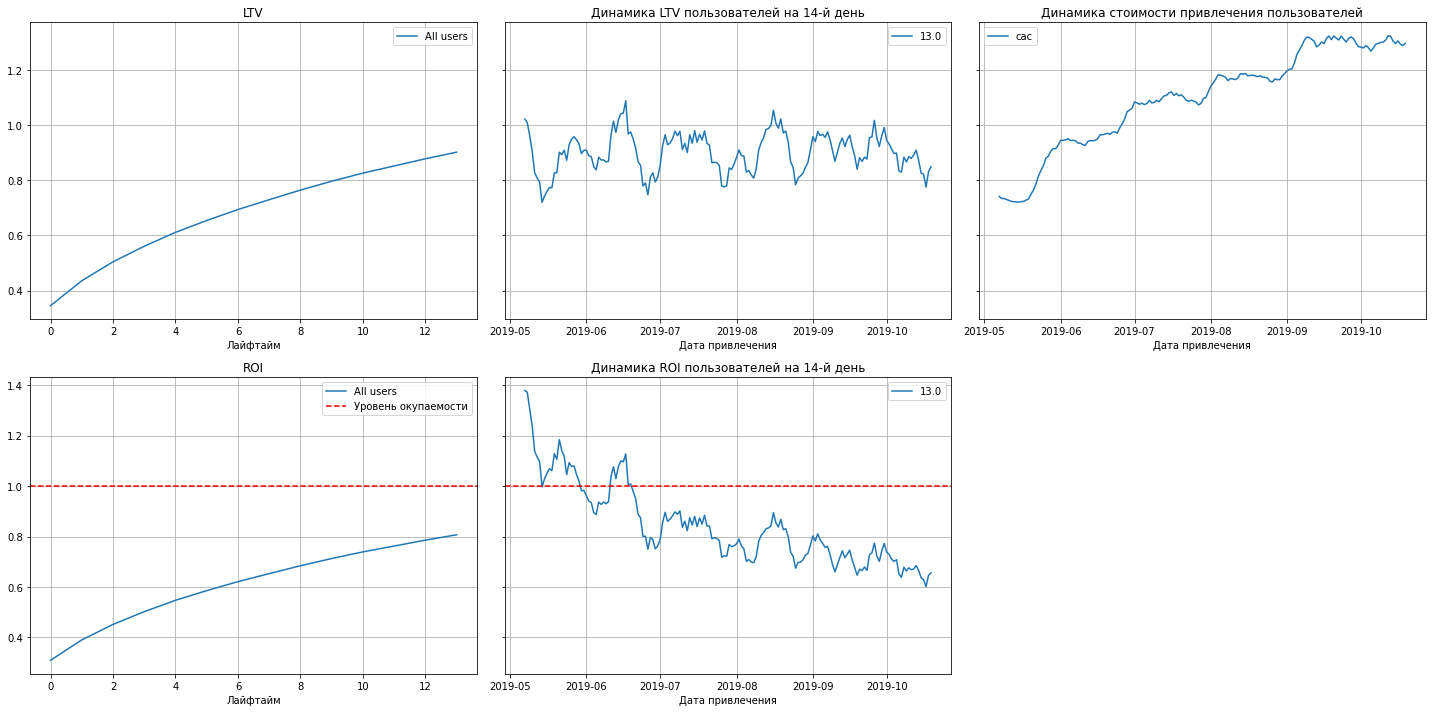

In [49]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    По графикам можно сделать следующие выводы:
    
- Реклама не окупается, к концу второй недели ROI на уровне 80%
- Стоимость привлчения одного пользователя с мая до октябрь значительно возрасла
- Реклама окупалась до июня, затем был положительный скачек в середине июня, а после ROI шел на спад, что в целом говорит о том, что привлечение пользователей не окупаетя
- LTV и ROI не снижаются, следовательно ошибка исключена
- По графику динамики LTV нельзя сказать, что он подвержен сезонности, но наблюдается переодический прирост в середине месяца.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

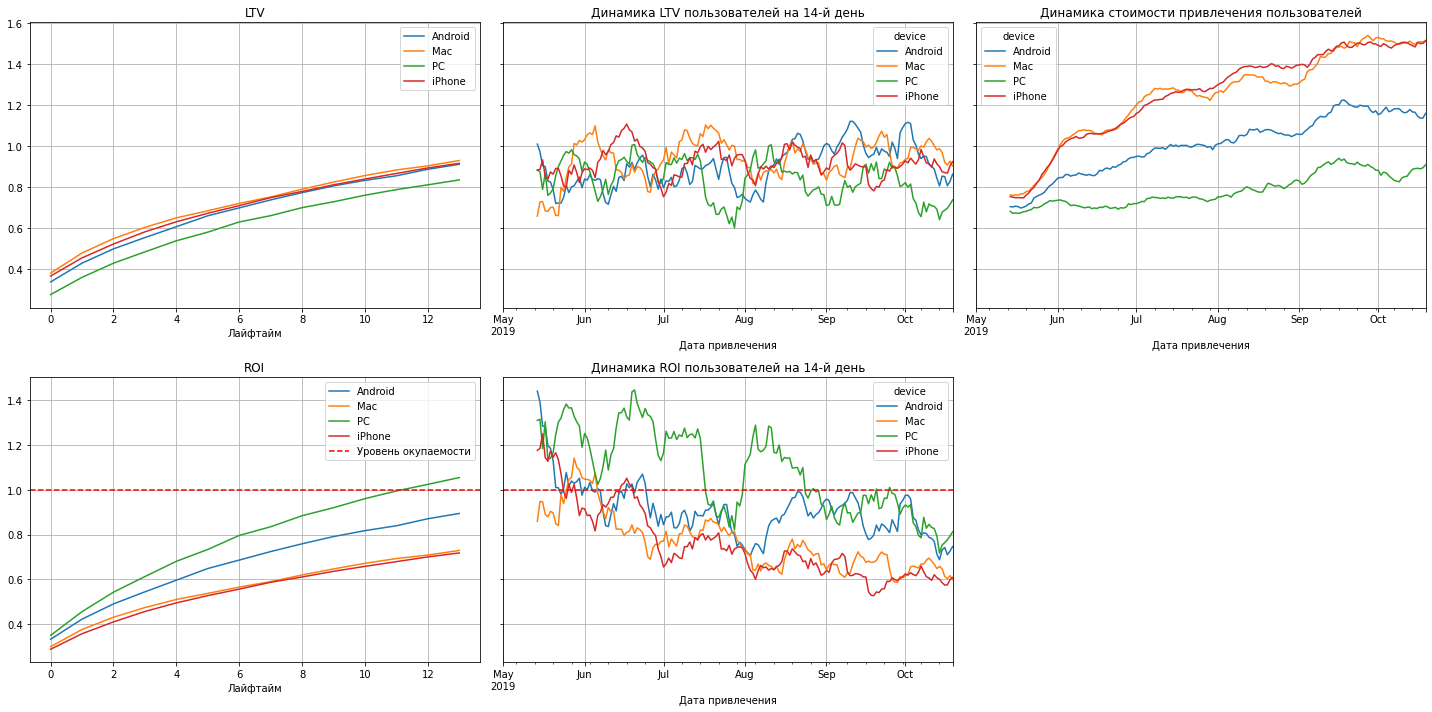

In [50]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
- Самый низкий уровень окупаемости у ползователей Iphone и Mac (около 70%)
- Окупаемость пользователей Android составляет примерно 90 %
- PC единственное устройство, привлечение пользователей которых окупилось (окупаемость на 11 день).

_Учитывая, что Iphone - самое популярное устройство среди пользователей приложения, странно, что нет окупаемости. Возможно существуют какие-то проблемы с функционалом приложения на данном устройстве (например проблема с оплатой)_
    
- Динамика ROI говорит о том, что к концу исследуемого периода окупаемости пользователей нет ни на одном из устройств. С мая по конец августа окупались только пользователи PC (однако был спад в конце июля). Далее спадающий тренд. 
- Остальные устройства (помимо PC) показывают стабильное падение в динамике окупаемости
- Самая стабильная стоимость привлечения для пользователей PC. 
- Заметен рост стоимости привлечения пользователей Android.
- Практически одинаково росла стоимость привлечения пользователей "яблочных" устройств. Данные пользователи самые дорогие с точки зрения привлечения.
    
Пока самым выгодным для вложений являются пользователи PC и самыми не выгодными - пользователи Iphone и Mac     

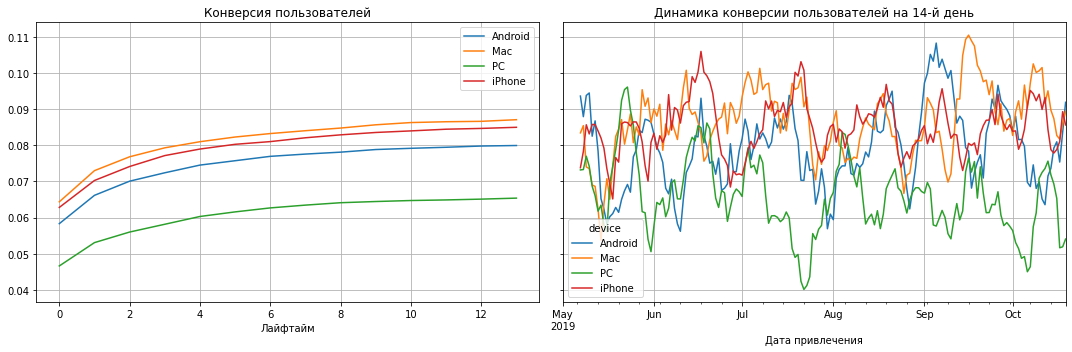

In [51]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
- Конверсия на всех устройствах не падает, значит с данными и расчетами все в порядке.
- Интересно, но пользователи PC конвертируются хуже всего (это подтверждается ранее сделаными выводами, на данном устройстве меньше всего платящих пользователей.
- Интересно, что самая хорошая конверсия, с точки зрения графика динамики конверсии у пользователей Iphone и Mac, возможно столь низкие показатели окупаемости связаны с удержанием этих пользователей.

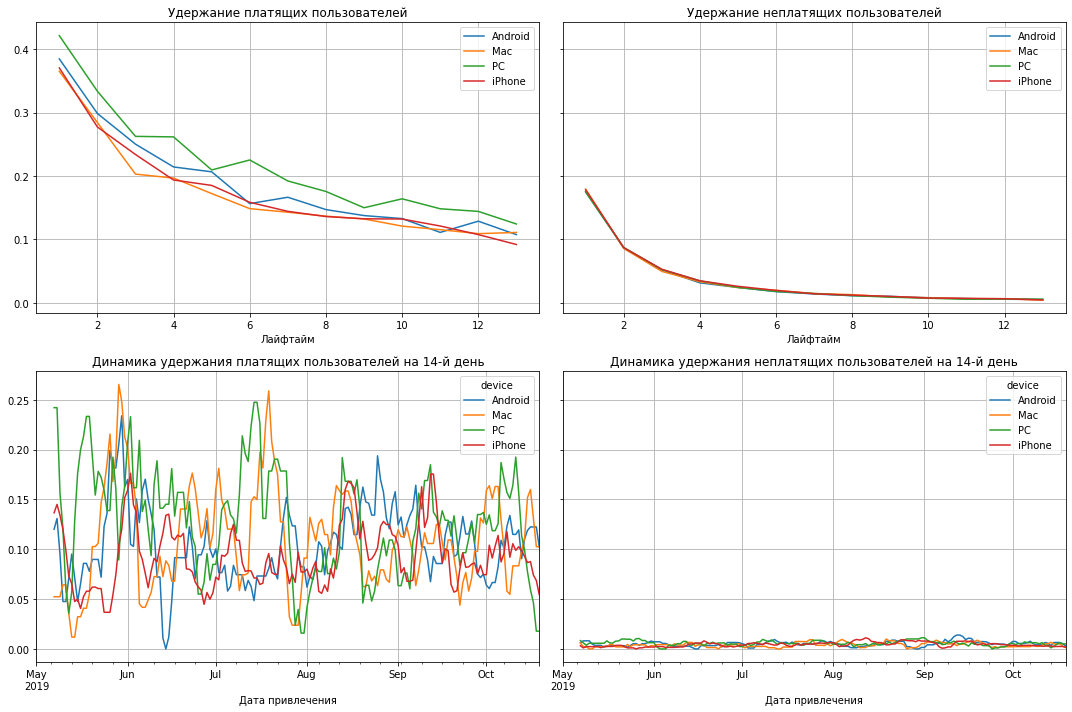

In [52]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
- Неплатящие пользователи удерживаются абсолютно одинаково и плохо
- Платящие пользователи удерживаются очень динамично. Ярко выраженного устройства-лидера нет, но ниже всего динамика у Iphone и Mac (возможно, это еще одно подтверждение, что приложение некорректно ратает на данных устройствах). 

### Проанализируйте окупаемость рекламы с разбивкой по странам

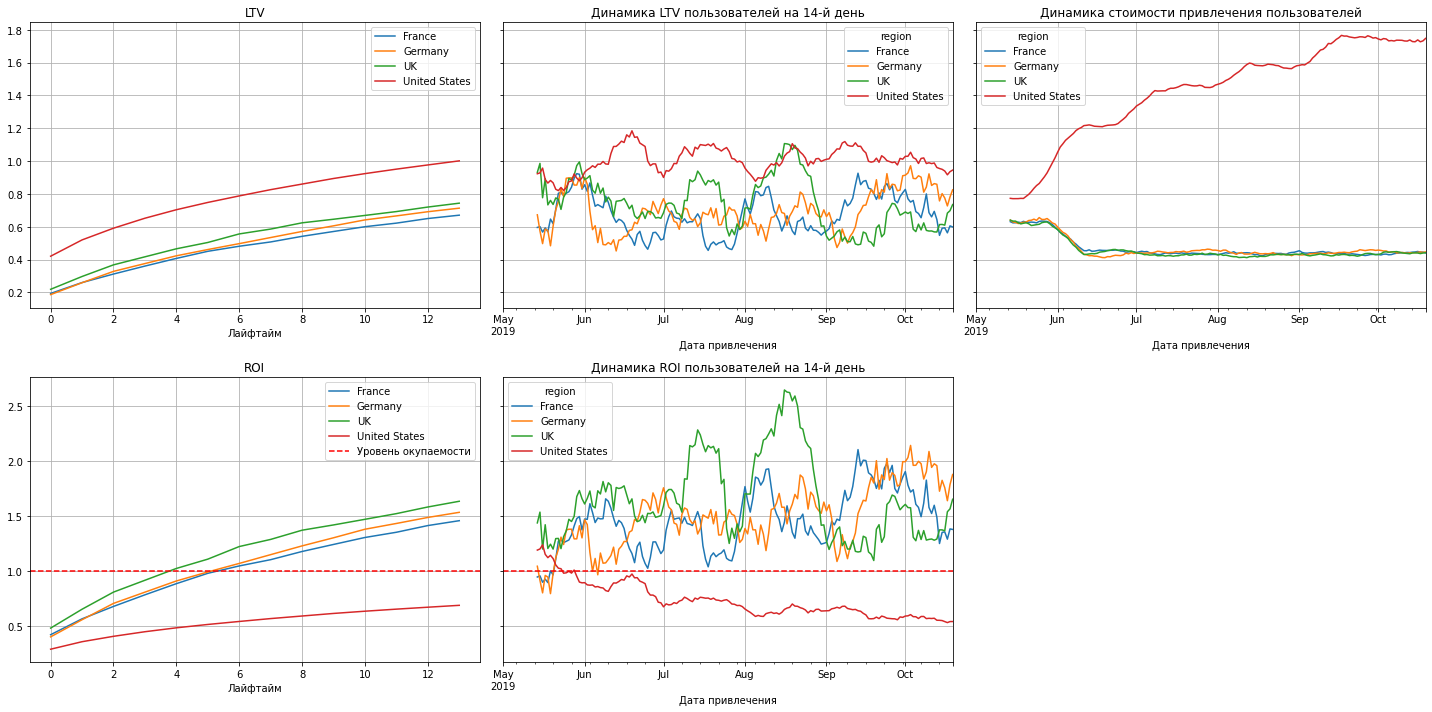

In [53]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
- Бросается в глаза как сильно возрасла стоимость привлечения пользователей из США, учитывая, что стоимость привлечения пользователей из других стран наоборот упала.
- Реклама окупилась везде кроме США (окупаемость Германии, Франции и Великобритании наступили от 4 на 6 день, что хороший показатель)
- Пользователи из Великобиритании показывают самую высокую динамику окупаемости в июле и в августе. СТоит отдельно обратить, на особенности рекламной кампании в эти месяцы в этом регионе.
- Ранее было определено, что из США самвые высокие показатели привлечения пользователей, вероятнее всего именно в США самый большой процент яблочных устройсвт. Скорее всего именно этим определен рост стоимости пользоватля. Интересно посмотреть конверсию и удержание. 

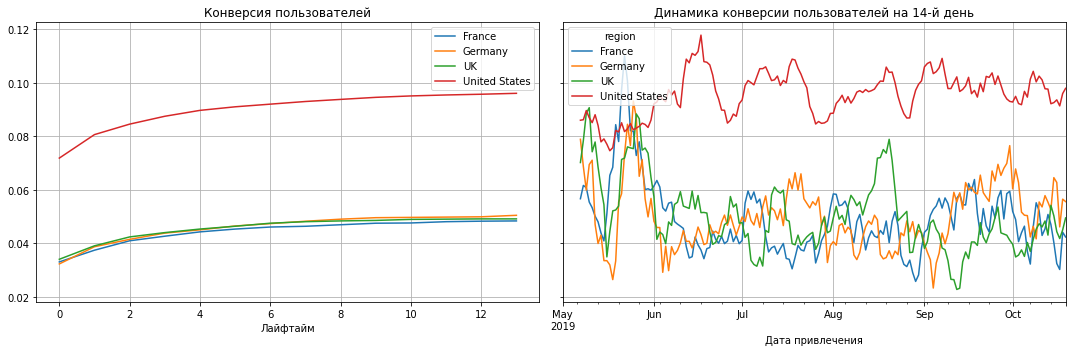

In [54]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
- Самая высокая конверсия у пользователей из США (однако все равно ниже 10%)
- Динамика конверсии пользователей из США почти вдвое выше, чем у пользователей из других стран, почти на всем исследуемом периоде (кроме мая, в мае наблюдается скачок конверсии у пользователей из Франции)


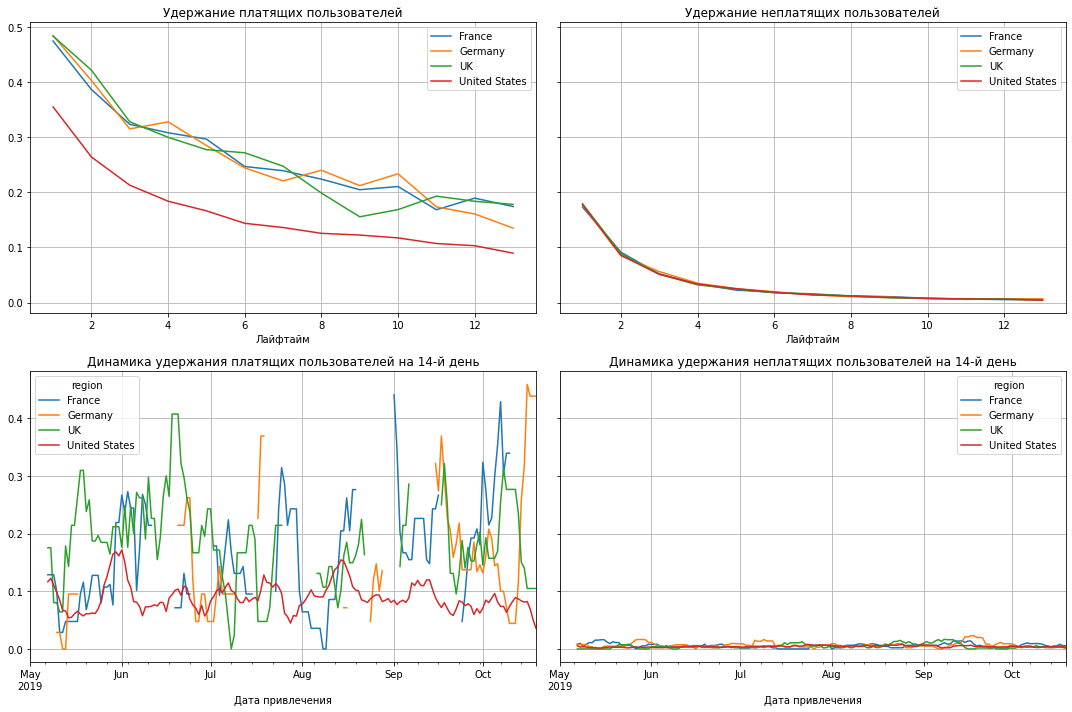

In [55]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">
    
- хуже всего удерживаются платящие пользователи из США.
- удержание неплатящих пользователей снова имеет одинаково низкие показатели
- интересные графики динамики удержания платящих пользователей из Великобритании, Франции и Германии - графики обрываются. Возможно это объясняется тем, что в этот период в регионе не было платящих пользователей.
    
После этого этапа самым невыгодным для привлечения является пользователь из США использующих яблочное утройство. Но отказываться от них нельзя - их больше всего. Нужно изучить пробремы (например журнал событий и ошибок, в случае его отсутсивия запросить обратную связь и изучить отзывы в сети и в магазинах приложений).    

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

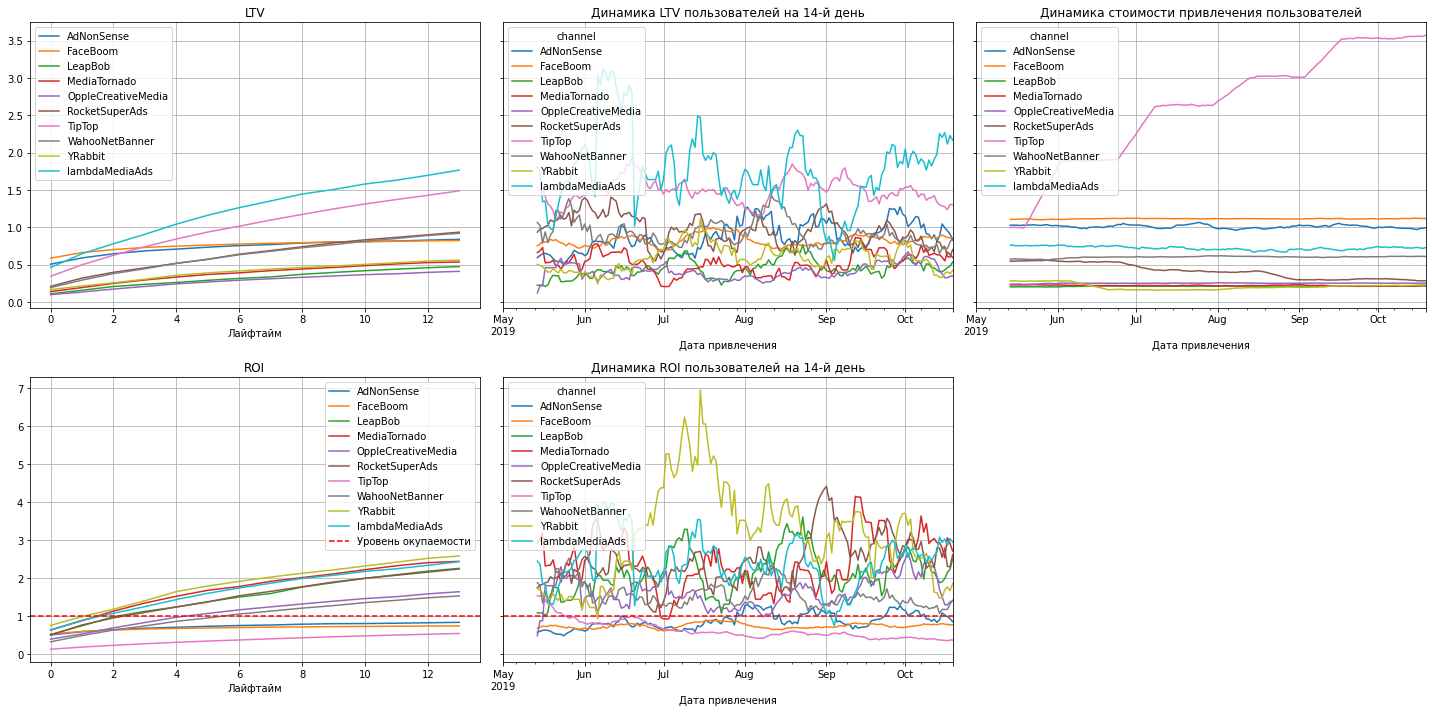

In [56]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">

- стоимость привлечения пользователей из всех каналов стабильна за весь период, кроме пользователей, пришедших из TipTop, их рост начался почти сразу и продолжался до самого конца исследуемого периода. Такой же вывод был сделан в этапе 4.2
- большая часть каналов окупилась в первую неделю (7 из 10)
- оставшиеся 3 канала не окупились вовсе - TipTop, FaceBoom, AdNonSense 
- в июле заметен скачок окупаемости YRaddit.
- 3 неокупившихся за 14 дней канала не окупались ни разу за весь исследуемый период (странно, ведь, TipTop, FaceBoom привели наибольшее число платящих пользователей).
    

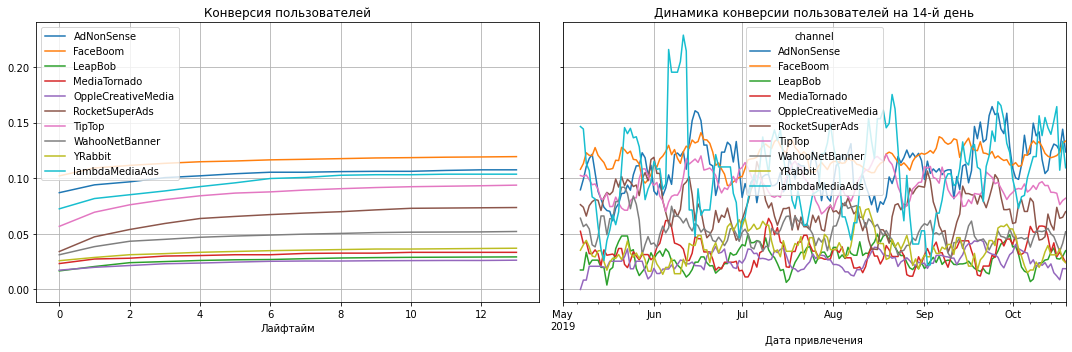

In [57]:
# смотрим конверсию с разбивкой по источникам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">

- канал FaceBoom  конвертируется лучше всего
- у остальных каналов конверсию можно назвать стабильной (кроме одного канала LambdaMediaAds   

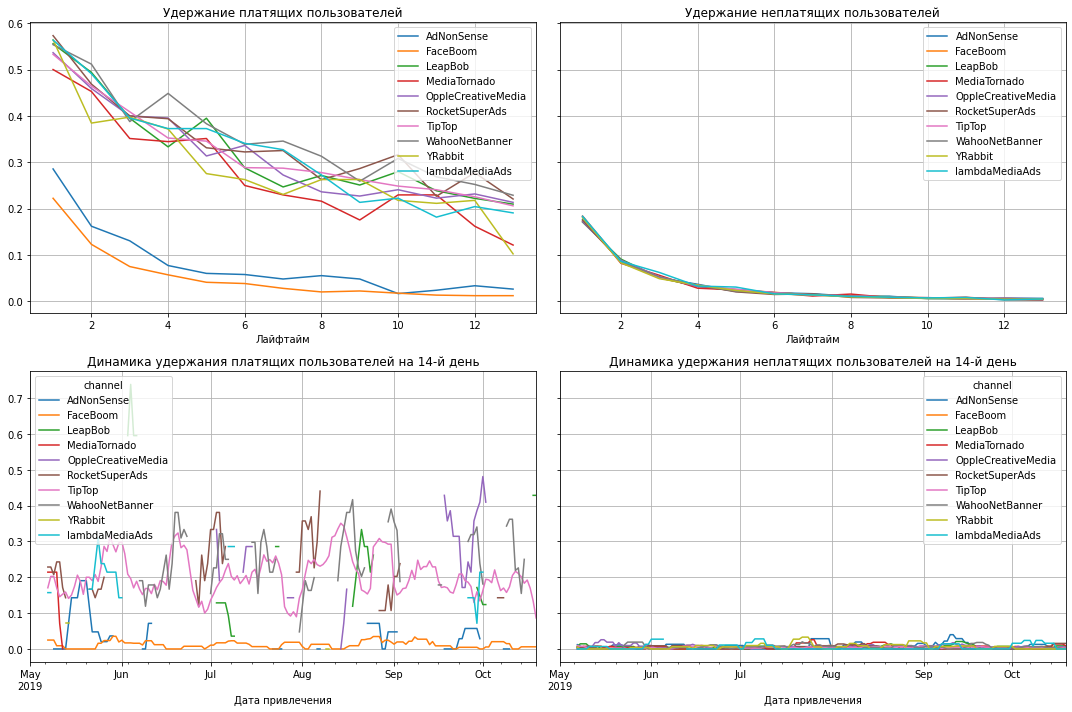

In [58]:
# смотрим удержание с разбивкой по источникам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Выводы по этапу
<div style="border:solid black 1px; padding: 10px">

- все чудесатее и чудесатее - не смотря на конверсию и привлечение, у FaceBoom самый низкий показатель удержания. Вместе с ним антирейтинг возглавляет AdNonSense.
- остальные каналы удерживают платящих пользователей примерно одинаково, и со ниспадающим трендом. 

По ранее сделанным выводам мне известно, что самая большая часть рекламных расходов уходит в TipTop и FaceBoom, при чем эти каналы не окупаются. Также я знаю, что не реклама в принципе не окупается только в США. Проверю одно предположение

In [59]:
profiles_1 = profiles.groupby(['region', 'channel']).agg({'user_id': 'nunique'})
profiles_1

user_id
region        channel                    
France        AdNonSense             1366
              LeapBob                2988
              OppleCreativeMedia     2991
              WahooNetBanner         2971
              lambdaMediaAds          742
Germany       AdNonSense             1219
              LeapBob                2519
              OppleCreativeMedia     2562
              WahooNetBanner         2579
              lambdaMediaAds          649
UK            AdNonSense             1295
              LeapBob                3046
              OppleCreativeMedia     3052
              WahooNetBanner         3003
              lambdaMediaAds          758
United States FaceBoom              29144
              MediaTornado           4364
              RocketSuperAds         4448
              TipTop                19561
              YRabbit                4312

In [60]:
profiles_2 = profiles.groupby(['region', 'device']).agg({'user_id': 'nunique'})
profiles_2

user_id
region        device          
France        Android     3313
              Mac         1163
              PC          4384
              iPhone      2198
Germany       Android     2849
              Mac         1020
              PC          3797
              iPhone      1862
UK            Android     3243
              Mac         1086
              PC          4551
              iPhone      2274
United States Android    12436
              Mac        15424
              PC          6421
              iPhone     27548

#### Вывод по догадке о США
<div style="border:solid black 2px; padding: 20px">

Предположение подтвердилось.


- Рекламные каналы TipTop и FaceBoom использовались только для пользователей из США
- В США самое высокое число пользователей iPhone и Mac (в несколько раз больше, в остальных регионах вместе взятых).
- В рекламу в этих каналах стабильно вкладывались, так как они приводили в приложение большое число пользователей (больше, чем в остальных регионах), однако они не окупаются. 

## Шаг 6. Общие выводы
<div style="border:solid black 2px; padding: 20px">

<b>Общая картина:</b>  
    
- Приложение популярнее всего в США - 67% пользователей
- На США же приходится самая большая часть платящих пользователей
- Самый большой процент пользователей используют "яблочные" устройства
- Самый большой % пользователей iPhone и Mac именно в США
- Больше всего пользователей привели каналы из США - FaceBoom и TipTop 

<b>Вложения в рекламу:</b> 
    
- Общие расходы на рекламу составили 105497 у.е.
- 51% этого бюджета забрал TipTop	
- 30% от общей суммы расходов были вложены в FaceBoom 
- Больше всего вложений в рекаламу было в сентябре 2019 года
- 86% рекламного бюджета ушли на рынок США (TipTop и FaceBoom работали только на этот регион)

<b>Стоимость привлчения пользователя:</b> 
    
- Средняя стоимость привлечения 1 бользователя составила около 1,13 у.е.
- Стоимость привлечения пользователя из канала TipTop почти в 3 раза выше средней - 2,8 у.е.
- Самые дорогие пользователи привлечены из США    

<b>Окупаемость рекламы:</b>  
    
- Реклама не окупилась только в США
- Но в целом реклама не окупилась, окупаемость всего 80% 
- Стоимость привлечения пользователя росла с каждым месяцем
- Самый низкий уровень окупаемости у пользователей iPhone и Mac 
- Польностью окупились только пользователи PC
- Из всех каналов не окупились только TipTop, FaceBoom, AdNonSense


### Причины неэффективности привлечения пользователей
<div style="border:solid red 2px; padding: 20px">
    
Основные причины провала рекламной кампании:

- Вложения в TipTop, FaceBoom - это каналы забрали львиную долю рекламного бюджета привлекали пользователей только из США. Низкий показатель окупаемости пользователей из США повлиял на всю рекламу в целом, так как именно эти пользователя составляют большую (значительную) долю пользователей приложения. 
- Проблема на устройствах iPhone и Mac - именно эти устройства окупаются хуже всего. Также не окупаются пользователи Android, возможно есть проблема в мобильной версии приложения и версии для Mac  
- Недостаточное внимание к Европейскому рынку, большая часть бюджета уходит на рынок США


### Рекомендации для отдела маркетинга для повышения эффективности
<div style="border:solid blue 2px; padding: 20px">

<b>Рынок США:</b>   
- пересмотреть расходы на вложение в канал TipTop - стоимость впривлечения высокая, окупаемости нет. Необходимо сократить затраты на этот канал и направить, например, на европейский рынок, так как пользователей США уже больше, и стоит проработать, в первую очередь, вопрос почему они не совершают покупки.
- выяснить причины неокупаемости канала FaceBoom - не смотря на высокие показатели привлечения пользователей, одинаковую стоимость привлечения пользователя и увеличение вложений, он не окупается. Выяснить низкие показатели удержания также как и у канала AdNonSense.   
- тот факт, значительная доля пользователей - это представители США может объясняться громандными вложениями на рекламу в американские каналы. Необходимо пересмотреть расходы, и перерасприделить их часть на Европейский рынок  
    
<b>Европейский рынок: </b>    
- Европейский рынок практически не получает внимания, по сравнению с рынком США. Необходимо перераспределить бюджет в его пользу. Можно обратить внимание на то, что лучше всего окупается Германия и Великобритания. 
- Можно обратить внимание на канал WahooNetBanner - 3 место по числу привлеченных пользователей, неплохой уровень конвертации и низкая стоимость привлечения 1 пользователя (0,60 у.е., что почти в 2 раза наже средней).     

<b>Рекомендации по привлеченным пользователям: </b>    
- выяснить куда пропадают "платящие" пользователи (прерывистый график). Возможно стоит ввести программу лояльности для платящих пользователей и давать промокоды на скиду при повторной оплате.    
- канал organic, который к тому же бесплатный, привлекает очень много пользователей и только 2% из них совершают покупки. Неоходимо разработать программы побуждения к покупке (промокоды, скидки, индивидуальные предложения)
- снижение удержания пользователей может говорить о том, что пользователей не устраивает платный конктент приложения. Нужно изучить обратную связь. 
    
<b>Рекомендации к разработке: </b> 
- изучить отчеты об ошибках и отзывы пользователей, возможно имеется проблема с оплатами для пользователей iPhone и Mac. Также возможно есть проблемы на мобильной версии приложения для Android.   
- возможно стоит собрать обратную связь (например через всплывающее уведомление), чтобы уточнить почему пользователи перестают пользоваться приложением   